In [98]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [241]:
import tqdm
import pandas as pd
pd.set_option('display.max_colwidth', 150)
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import regex as re
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score
import seaborn as sns

In [153]:
#import train data
train = pd.read_csv("data/training_set.txt", sep="	", engine='python', names=["sentence","emotion"], skiprows=1)
test = pd.read_csv("data/dev_set.txt", sep="	", engine='python', names=["sentence","emotion"], skiprows=1)

In [101]:
# size of the dataset and null values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  14000 non-null  object
 1   emotion   14000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 218.9+ KB


In [102]:
# check if the emotions are correctly defined:
print(np.sort(train['emotion'].unique()))

# check the distribution of sentences in each emotion class:
df = train.groupby('emotion').count().reset_index()
sum_total = df['sentence'].sum()
df['perc_total'] = round(df['sentence']/sum_total,2)
df

[1 2 3 4 5 6 7 8]


,emotion,sentence,perc_total
0,1,2999,0.21
1,2,2129,0.15
2,3,1343,0.10
3,4,1442,0.10
4,5,1470,0.10
5,6,1384,0.10
6,7,1138,0.08
7,8,2095,0.15


# training data

In [147]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   sentence           14000 non-null  object
 1   emotion            14000 non-null  int64 
 2   sentence_prep      14000 non-null  object
 3   final_ponctuation  14000 non-null  object
dtypes: int64(1), object(3)
memory usage: 437.6+ KB


In [245]:
def preprocessing(dataframe, column):
    
    processed_corpus = []
    stop_words = set(stopwords.words("english"))
    
    for i in (range(len(dataframe))):
        text = dataframe[column].iloc[i]
        
        # Remove tags
        text = BeautifulSoup(text).get_text()
        
        # Remove punctuations - mantain only the final . or !
        text = re.sub("[^a-zA-z!.?:'\s]", '', text)
        text = re.sub("[.]{2,}", '', text)

        # Convert to lowercase
        text = text.lower()        
        
        # Convert to list from string
        text = text.split()

        # Lemmatization
        lem = WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text if not word in stop_words] 
        text = " ".join(text)
        processed_corpus.append(text)
    dataframe['sentence_prep'] = processed_corpus
        
    return dataframe

In [246]:
train = preprocessing(train, 'sentence')

E:\Programs\envs\nova_tx\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [247]:
train.head()

,sentence,emotion,sentence_prep,final_ponctuation
0,I'm too old to be traded in .,6,i'm old traded .,.
1,Mother said you could always tell a lady by her hands .,8,mother said could always tell lady hand .,.
2,I always said I'd leave off when the time came .,6,always said i'd leave time came .,.
3,He'll be safe with me .,2,he'll safe .,.
4,Lay off .,1,lay .,.


In [248]:
#feature extraction 
vectorizer = TfidfVectorizer(stop_words=None, max_df=.8, strip_accents='unicode', lowercase=False, analyzer='word')
X = vectorizer.fit_transform(train['sentence_prep']).toarray()
Y = train['emotion']
X.shape, Y.shape

((14000, 6580), (14000,))

# test data

In [249]:
#test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sentence       1000 non-null   object
 1   emotion        1000 non-null   int64 
 2   sentence_prep  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [250]:
test['emotion'].unique()

array([4, 8, 7, 2, 1, 3, 6, 5], dtype=int64)

In [251]:
test = preprocessing(test, 'sentence')
test.head()

,sentence,emotion,sentence_prep
0,What happens to the gold in our safe ?,4,happens gold safe ?
1,Natural to get cold feet .,8,natural get cold foot .
2,"Not very lucky , is he ?",7,lucky ?
3,"I'm just a little anxious to get up there and whoop ET's ass , that's all .",2,i'm little anxious get whoop et's as that's .
4,Did you think we don't know about your affair with a government official ?,1,think know affair government official ?


In [252]:
X_test = vectorizer.transform(test['sentence_prep']).toarray()
Y_test = test['emotion']
X_test.shape, Y_test.shape

((1000, 6580), (1000,))

## Model - baseline LogisticRegression

In [253]:
clf = LogisticRegression(random_state=0, max_iter=1000, class_weight='balanced').fit(X, Y)
Y_pred = clf.predict(X_test)

In [254]:
print('accuracy: ', clf.score(X_test, Y_test))

accuracy:  0.344


In [255]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(Y_test, Y_pred)}\n"
)

Classification report for classifier LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0):
              precision    recall  f1-score   support

           1       0.43      0.24      0.31       211
           2       0.40      0.38      0.39       170
           3       0.20      0.34      0.25        77
           4       0.35      0.41      0.38       104
           5       0.39      0.45      0.42        97
           6       0.27      0.33      0.30        87
           7       0.30      0.39      0.33        96
           8       0.42      0.31      0.36       158

    accuracy                           0.34      1000
   macro avg       0.34      0.36      0.34      1000
weighted avg       0.37      0.34      0.35      1000




In [256]:
cm = metrics.confusion_matrix(Y_test, Y_pred)
print(cm)
cm = pd.DataFrame(cm, index=range(1,9), columns=range(1,9))

[[51 22 38 27  5 29 21 18]
 [12 65 18 16 16  9 19 15]
 [12 10 26  5  5  7  5  7]
 [ 9  8  9 43  4 11 11  9]
 [ 3  8  9  2 44  8  9 14]
 [13 11  6  8  9 29  8  3]
 [ 5 15  9 12  7  9 37  2]
 [14 23 17 10 23  7 15 49]]


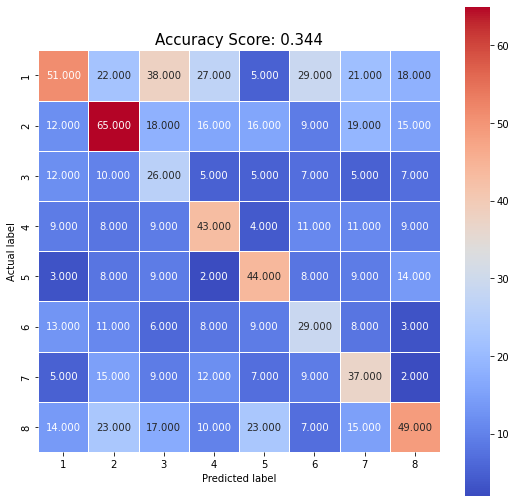

In [257]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'coolwarm');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [258]:
feature_names = vectorizer.get_feature_names_out()

In [260]:
print(feature_names)

['aa' 'aarfy' 'abandoned' 'abandoning' 'abdominal' 'abercrombie' 'abide'
 'ability' 'able' 'ably' 'aboard' 'abracadabra' 'absence' 'absolute'
 'absolutely' 'absolve' 'absolved' 'absurd' 'absurdly' 'abundance' 'abuse'
 'abused' 'abusive' 'accent' 'accept' 'acceptable' 'accepted' 'accepts'
 'access' 'accessory' 'accident' 'accommodate' 'accomplish' 'according'
 'account' 'accountable' 'accountant' 'accusation' 'accuse' 'accused'
 'accuses' 'ace' 'ache' 'ached' 'aching' 'acid' 'acknowledge'
 'acknowledging' 'acquaintance' 'acquainted' 'acquisition' 'acre' 'across'
 'act' 'acted' 'acting' 'action' 'active' 'activity' 'actress' 'actual'
 'actually' 'ad' 'adalind' 'add' 'addicted' 'additional' 'address' 'adept'
 'adiran' 'administration' 'administrative' 'admiral' 'admire' 'admired'
 'admiring' 'admission' 'admit' 'admitting' 'adolescence' 'adolescent'
 'adopt' 'adopted' 'adoption' 'adore' 'adrian' 'adrift' 'adult' 'advance'
 'advantage' 'adventure' 'advertising' 'advice' 'advise' 'adviser'
